In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
import joblib
import matplotlib.pyplot as plt
import math

In [3]:
# ===============================
# CONFIG
# ===============================
DATA_DIR = Path("data")
MODEL_DIR = Path("serialized")
MODEL_DIR.mkdir(exist_ok=True)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

T_CONTEXT = 24 * 3 # 3 дні
HORIZON   = 6 # 6 годин вперед
BATCH_SIZE = 64
EPOCHS = 10


Прогнозувати будемо energy_deficit_adj(t+1…t+6) погодинно, по регіонах. Контекстне вікно 3 дня

список фіч:
"demand_ua_adj","generation_ua_adj","energy_deficit_adj","alert_active", "isDamaged", "temperature","humidity","precipitation","snowfall","wind_speed","wind_gusts","cloud_cover","surface_pressure",

Година доби - циклічна змінна (23.00->00.00), нейромережа бачить різкий розрив, якого фізично не існує, тому модель не буде розуміти добових патернів. Для цього робимо проекцію на коло - представляємо годину як точку на одиничному колі, тоді 23 та 00 будуть не далеко як до цього, а поруч один до одного, тобто модель бачить добовий цикл. робимо це через синуси та косинуси)

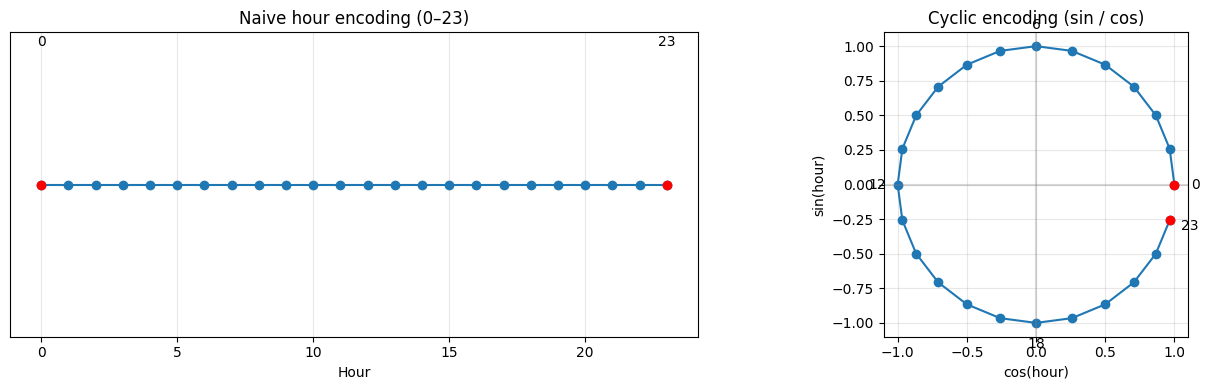

In [4]:
hours = np.arange(24)

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].plot(hours, np.zeros_like(hours), "o-")
axes[0].scatter([23, 0], [0, 0], color="red", zorder=5)

axes[0].text(23, 0.05, "23", ha="center")
axes[0].text(0, 0.05, "0", ha="center")

axes[0].set_title("Naive hour encoding (0–23)")
axes[0].set_xlabel("Hour")
axes[0].set_yticks([])
axes[0].grid(alpha=0.3)

theta = 2 * np.pi * hours / 24
x = np.cos(theta)
y = np.sin(theta)

axes[1].plot(x, y, "o-")
axes[1].scatter([x[23], x[0]], [y[23], y[0]], color="red", zorder=5)

for h in [0, 6, 12, 18, 23]:
    axes[1].text(x[h]*1.15, y[h]*1.15, str(h), ha="center", va="center")

axes[1].axhline(0, color="gray", alpha=0.3)
axes[1].axvline(0, color="gray", alpha=0.3)
axes[1].set_aspect("equal")

axes[1].set_title("Cyclic encoding (sin / cos)")
axes[1].set_xlabel("cos(hour)")
axes[1].set_ylabel("sin(hour)")
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [5]:
FEATURES = [ "demand_ua_adj", "generation_ua_adj", "energy_deficit_adj", "alert_active", "isDamaged", "temperature", "humidity", "precipitation", "snowfall", "wind_speed", "wind_gusts", "cloud_cover", "surface_pressure", "hour_sin", "hour_cos", ]
TARGET = "energy_deficit_adj"

# ===============================
# TIME FEATURES
# ===============================
def add_time_features(df):
    df = df.copy()
    hour = df["timestamp_utc"].dt.hour
    df["hour_sin"] = np.sin(2 * np.pi * hour / 24)
    df["hour_cos"] = np.cos(2 * np.pi * hour / 24)
    return df

# ===============================
# LOAD DATA
# ===============================
df = pd.read_csv(
    DATA_DIR / "ready2use_region_electricity.csv",
    parse_dates=["timestamp_utc"]
)

df = df[(df["timestamp_utc"] >= "2024-01-01") &
        (df["timestamp_utc"] <= "2025-01-01")].copy()

df = add_time_features(df)

REGIONS = sorted(df["ua_region"].unique())
R = len(REGIONS)
assert R == 27, f"Expected 27 regions, got {R}"

region_to_idx = {r: i for i, r in enumerate(REGIONS)}
df["region_idx"] = df["ua_region"].map(region_to_idx)

df = df.sort_values(["timestamp_utc", "region_idx"]).reset_index(drop=True)

# ===============================
# SPLIT (TIME-BASED)
# ===============================
timestamps = sorted(df["timestamp_utc"].unique())
split_t = timestamps[int(len(timestamps) * 0.8)]

df_train = df[df["timestamp_utc"] <= split_t].copy()
df_val   = df[df["timestamp_utc"] >  split_t].copy()

# ===============================
# SCALER (FIT ONLY ON TRAIN)
# ===============================
scaler = StandardScaler()
df_train[FEATURES] = scaler.fit_transform(df_train[FEATURES])
df_val[FEATURES]   = scaler.transform(df_val[FEATURES])

joblib.dump(scaler, MODEL_DIR / "scaler.pkl")

['serialized\\scaler.pkl']

In [6]:
FUTURE_FEATURES = [
    "alert_active",
    "isDamaged",
    "temperature",
    "wind_speed",
    "cloud_cover",
]

FUTURE_FEATURES_FLAT = []
for h in range(1, HORIZON + 1):
    for col in FUTURE_FEATURES:
        FUTURE_FEATURES_FLAT.append(f"{col}_f{h}")

In [7]:
# ===============================
# DATASET
# ===============================
class MultiRegionDataset(Dataset):
    def __init__(self, df, features, target, T_CONTEXT, HORIZON):
        self.features = features
        self.T = T_CONTEXT
        self.H = HORIZON
        self.timestamps = sorted(df["timestamp_utc"].unique())
        
        # X: (Час, Регіон, Фіча)
        self.X = np.zeros((len(self.timestamps), R, len(features)), dtype=np.float32)
        # Y: (Час, Регіон) — ТУТ ТЕПЕР СКАЛЬОВАНІ ДАНІ
        self.Y = np.zeros((len(self.timestamps), R), dtype=np.float32)

        self.FUT = np.zeros(
        (len(self.timestamps), len(FUTURE_FEATURES_FLAT)),
        dtype=np.float32
)

        for _, row in df.iterrows():
            t_idx = self.timestamps.index(row["timestamp_utc"])
            r_idx = row["region_idx"]
            self.X[t_idx, r_idx] = row[features].values
            self.Y[t_idx, r_idx] = row[target]
            self.FUT[t_idx] = row[FUTURE_FEATURES_FLAT].values


    def __len__(self):
        return len(self.timestamps) - self.T - self.H

    def __getitem__(self, idx):
        x_past = self.X[idx : idx + self.T]              # (T, R, F)
        x_future = self.FUT[idx + self.T]                # (F_future,)
        y = self.Y[idx + self.T : idx + self.T + self.H] # (H, R)

        return (
            torch.from_numpy(x_past),
            torch.from_numpy(x_future),
            torch.from_numpy(y),
    )


# ===============================
# DATALOADERS
# ===============================
train_ds = MultiRegionDataset(df_train, FEATURES, TARGET, T_CONTEXT, HORIZON)
val_ds   = MultiRegionDataset(df_val, FEATURES, TARGET, T_CONTEXT, HORIZON)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE)

In [16]:
class SystemEncoderDecoder(nn.Module):
    def __init__(
        self,
        num_regions=27,
        num_features=15, # Кількість ваших FEATURES
        hidden_dim=128,
        future_feat_per_step=5, # alert, damaged, temp, wind, cloud
        horizon=6
    ):
        super().__init__()
        self.R = num_regions
        self.H = horizon
        self.hidden_dim = hidden_dim
        
        # 1. Feature Compressor: Стискаємо ознаки кожного регіону окремо
        self.reg_compressor = nn.Sequential(
            nn.Linear(num_features, 32),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

        # 2. Encoder: Обробка часової послідовності (3 дні)
        # Вхід: R * 32 (стиснуті регіони)
        self.encoder_gru = nn.GRU(
            input_size=num_regions * 32,
            hidden_size=hidden_dim,
            num_layers=2,
            batch_first=True,
            bidirectional=True
        )

        # 3. Future Feature Processor: Готує дані про майбутнє
        # Оскільки x_future у вас плоский (BATCH, H * 5), ми його розіб'ємо
        self.future_encoder = nn.Linear(future_feat_per_step, 16)

        # 4. Decoder GRU: Прогнозує крок за кроком
        # Вхід: прихований стан енкодера + ознаки конкретної години в майбутньому
        self.decoder_cell = nn.GRUCell(
            input_size=16 + (num_regions * 1), # майбутні фічі + останній відомий дефіцит
            hidden_size=hidden_dim * 2 # бо енкодер bidirectional
        )

        # 5. Output Head: Перетворює стан декодера в дефіцит для всіх регіонів
        self.out_head = nn.Sequential(
            nn.Linear(hidden_dim * 2, 64),
            nn.ReLU(),
            nn.Linear(64, num_regions)
        )

        self.target_idx = 2 # Індекс energy_deficit_adj у FEATURES (перевірте!)

    def forward(self, x_past, x_future):
        """
        x_past: (B, T, R, F) -> (Batch, 72, 27, 15)
        x_future: (B, H * 5) -> (Batch, 30) - вже розгорнуті фічі на 6 годин
        """
        B, T, R, F = x_past.shape
        
        # --- ENCODING ---
        # Стискаємо регіони: (B, T, R, F) -> (B, T, R, 32) -> (B, T, R*32)
        x_compressed = self.reg_compressor(x_past.reshape(B*T*R, F)).view(B, T, R*32)
        
        # Проганяємо через GRU
        _, h_n = self.encoder_gru(x_compressed) 
        # h_n має розмір (num_layers*2, B, hidden_dim). Об'єднуємо шари:
        h_t = torch.cat([h_n[-2], h_n[-1]], dim=-1) # (B, hidden_dim * 2)

        # --- DECODING (Autoregressive) ---
        # Початкове значення - останній дефіцит з історії
        current_deficit = x_past[:, -1, :, self.target_idx] # (B, R)
        predictions = []
        
        # Розбиваємо x_future на 6 кроків по 5 фіч
        future_steps = x_future.view(B, self.H, -1) 

        for i in range(self.H):
            # Фічі на поточний крок прогнозу (температура, тривога тощо)
            f_step = self.future_encoder(future_steps[:, i, :]) # (B, 16)
            
            # Вхід декодера: прогноз попереднього кроку + фічі майбутнього
            decoder_in = torch.cat([current_deficit, f_step], dim=-1)
            
            # Крок GRU
            h_t = self.decoder_cell(decoder_in, h_t)
            
            # Генерація дефіциту для всіх регіонів одночасно
            out = self.out_head(h_t) # (B, R)
            predictions.append(out)
            current_deficit = out # Feedback loop

        # Складаємо в (B, H, R)
        return torch.stack(predictions, dim=1)

In [18]:
model = SystemEncoderDecoder(R, len(FEATURES)).to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)
loss_fn = nn.HuberLoss(delta=1.0)

In [20]:
best_val_loss = float("inf")

for epoch in range(EPOCHS):
    # ================= TRAIN =================
    model.train()
    train_loss = 0.0

    for Xb, Fb, yb in train_loader:
        Xb = Xb.to(DEVICE)
        Fb = Fb.to(DEVICE)
        yb = yb.to(DEVICE)

        optimizer.zero_grad()
        pred = model(Xb, Fb)
        loss = loss_fn(pred, yb)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)

    # ================= VALIDATION =================
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for Xb, Fb, yb in val_loader:
            Xb = Xb.to(DEVICE)
            Fb = Fb.to(DEVICE)
            yb = yb.to(DEVICE)

            pred = model(Xb, Fb)
            val_loss += loss_fn(pred, yb).item()

    val_loss /= len(val_loader)

    scheduler.step(val_loss)

    print(
        f"Epoch {epoch:02d} | "
        f"Train: {train_loss:.4f} | "
        f"Val: {val_loss:.4f} | "
        f"LR: {optimizer.param_groups[0]['lr']:.6f}"
    )

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), MODEL_DIR / "system_gru_best.pt")



Epoch 00 | Train: 0.0842 | Val: 0.3463 | LR: 0.001000
Epoch 01 | Train: 0.0825 | Val: 0.3395 | LR: 0.001000
Epoch 02 | Train: 0.0813 | Val: 0.3311 | LR: 0.001000
Epoch 03 | Train: 0.0799 | Val: 0.3298 | LR: 0.001000
Epoch 04 | Train: 0.0787 | Val: 0.3318 | LR: 0.001000
Epoch 05 | Train: 0.0776 | Val: 0.3340 | LR: 0.001000
Epoch 06 | Train: 0.0762 | Val: 0.3429 | LR: 0.001000
Epoch 07 | Train: 0.0747 | Val: 0.3490 | LR: 0.000500
Epoch 08 | Train: 0.0730 | Val: 0.3512 | LR: 0.000500
Epoch 09 | Train: 0.0722 | Val: 0.3544 | LR: 0.000500


Було протестовано різні архітектури.

Train Loss та Val Loss дуже близькі і обидва перестали падати, це означає, що у нас Underfitting(недонавчання) або, більш ймовірніше в цій задачі - Data Saturation (насичення даних).

Це ситуація, коли модель "витиснула" з наданих даних усе, що фізично можливо. Подальше ускладнення архітектури не дає результату, бо в самих даних не вистачає інформації для точнішого прогнозу.

In [21]:
# ===============================
# LOAD MODEL + SCALER
# ===============================
scaler = joblib.load(MODEL_DIR / "scaler.pkl")

model = SystemEncoderDecoder(R, len(FEATURES)).to(DEVICE)
model.load_state_dict(
    torch.load(MODEL_DIR / "system_gru_best.pt", map_location=DEVICE)
)
model.eval()

# ===============================
# ВИБИРАЄМО ОСТАННЄ ВІКНО З VAL
# ===============================
idx = 0
X_sample, F_sample, Y_true = val_ds[idx]

X_sample = X_sample.unsqueeze(0).to(DEVICE)   # (1, 72, 27, F)
F_sample = F_sample.unsqueeze(0).to(DEVICE)   # (1, F_future)

with torch.no_grad():
    Y_pred_scaled = model(X_sample, F_sample).cpu().numpy()[0]  # (6, 27)


print("Model output shape:", Y_pred_scaled.shape)
print("Raw model output (scaled):")
print(f"[{Y_pred_scaled[0]}")


Model output shape: (6, 27)
Raw model output (scaled):
[[-0.25295123 -0.31897196 -0.2586404  -0.34324253  0.08344831 -0.32642543
 -0.27300417 -0.27032396 -0.03067253 -0.01758683  0.03939804 -0.38179696
 -0.3831751  -0.0977504  -0.2792315   0.26122934 -0.3128615  -0.22849911
 -0.27602094 -0.2456451   0.14718114 -0.33267188 -0.33284572 -0.23191851
 -0.29006588 -0.25954658 -0.33860618]


Visualizing region: Київ index: 9


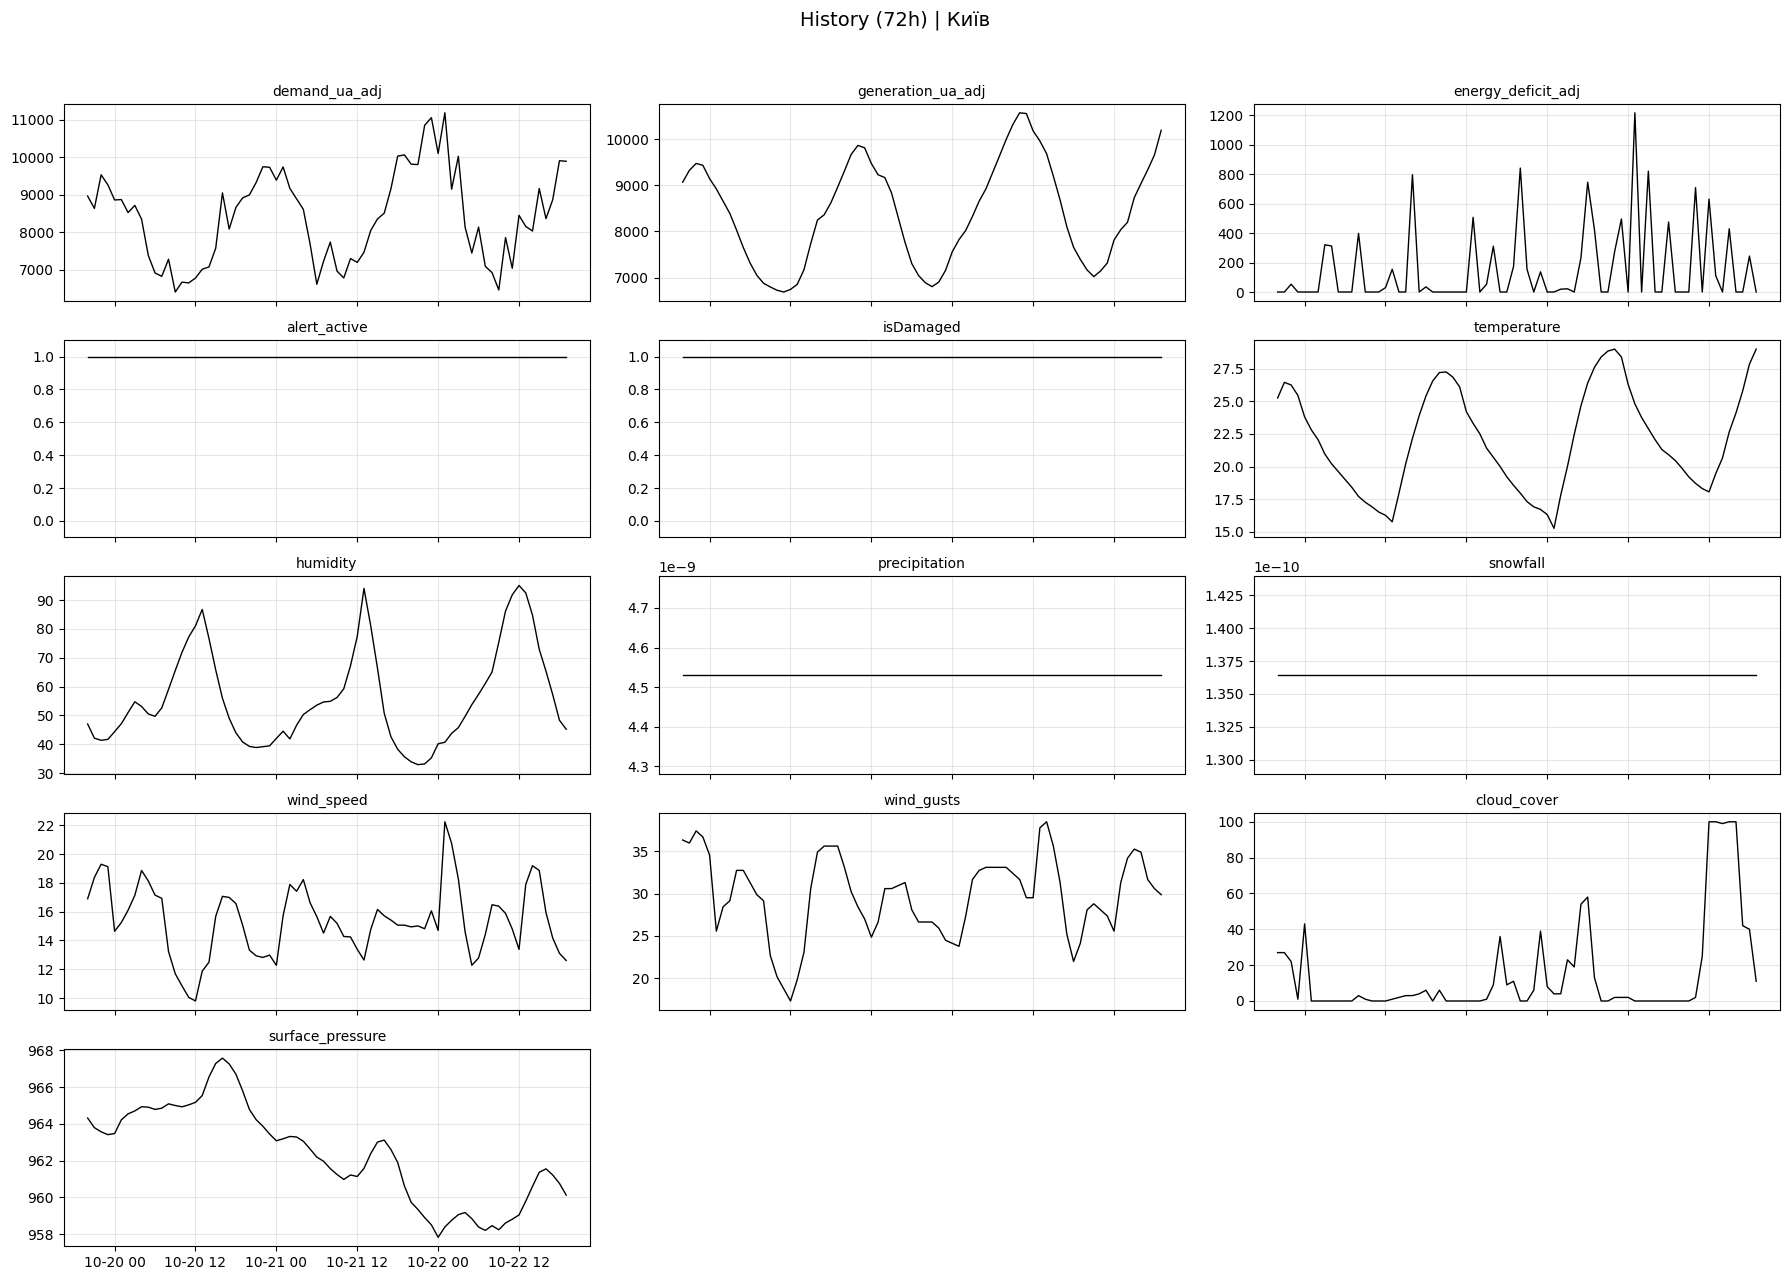

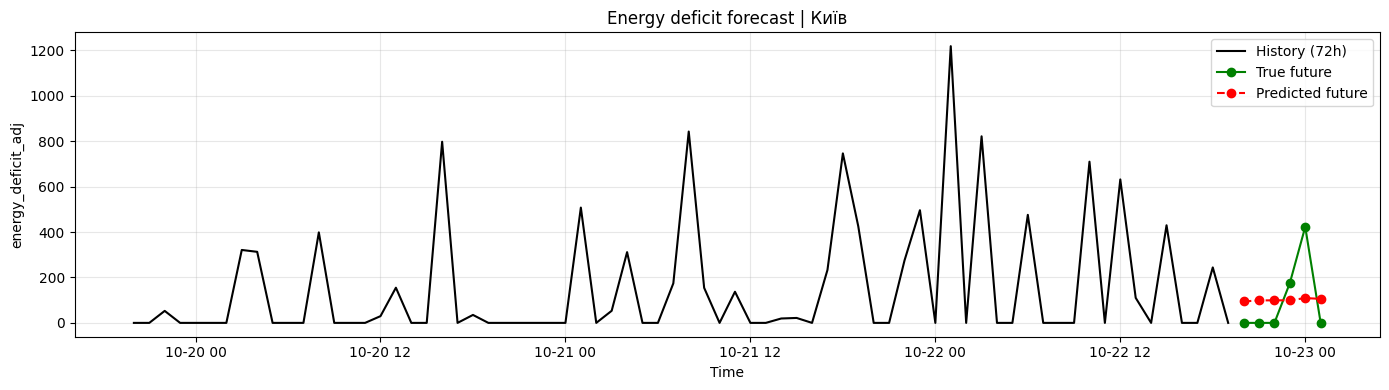

In [22]:
# ===============================
# DENORMALIZE TARGET
# ===============================
target_idx = FEATURES.index(TARGET)
mean = scaler.mean_[target_idx]
std  = scaler.scale_[target_idx]

Y_pred = Y_pred_scaled * std + mean
Y_true_real = Y_true * std + mean


# ===============================
# REGION SELECTION
# ===============================
REGION_NAME = "Київ"
r_idx = region_to_idx[REGION_NAME]

print("Visualizing region:", REGION_NAME, "index:", r_idx)

# ===============================
# TIME ALIGNMENT (FIXED)
# ===============================
val_times = val_ds.timestamps

time_hist = val_times[idx : idx + T_CONTEXT]
time_fut  = val_times[idx + T_CONTEXT : idx + T_CONTEXT + HORIZON]

# ===============================
# HISTORY FEATURES (NO hour_*)
# ===============================
HISTORY_FEATURES = [
    f for f in FEATURES
    if not f.startswith("hour_")
]

X_hist_scaled = X_sample.cpu().numpy()[0, :, r_idx, :]  # (72, F)

X_hist = X_hist_scaled.copy()
for i in range(len(FEATURES)):
    X_hist[:, i] = (
        X_hist_scaled[:, i] * scaler.scale_[i] + scaler.mean_[i]
    )

n_feat = len(HISTORY_FEATURES)
n_cols = 3
n_rows = math.ceil(n_feat / n_cols)

fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(18, 2.5 * n_rows),
    sharex=True
)

axes = axes.flatten()

for i, feat in enumerate(HISTORY_FEATURES):
    feat_idx = FEATURES.index(feat)

    axes[i].plot(
        time_hist,
        X_hist[:, feat_idx],
        color="black",
        linewidth=1
    )
    axes[i].set_title(feat, fontsize=10)
    axes[i].grid(alpha=0.3)

    if feat in ["isDamaged", "alert_active"]:
        axes[i].set_ylim(-0.1, 1.1)

for j in range(i + 1, len(axes)):
    axes[j].axis("off")

fig.suptitle(
    f"History (72h) | {REGION_NAME}",
    fontsize=14,
    y=1.02
)

axes[-1].set_xlabel("Time")

plt.tight_layout()
plt.show()

# ===============================
# FORECAST PLOT (TARGET ONLY)
# ===============================
plt.figure(figsize=(14, 4))

plt.plot(
    time_hist,
    X_hist[:, target_idx],
    label="History (72h)",
    color="black"
)

plt.plot(
    time_fut,
    Y_true_real[:, r_idx],
    marker="o",
    label="True future",
    color="green"
)

plt.plot(
    time_fut,
    Y_pred[:, r_idx],
    marker="o",
    linestyle="--",
    label="Predicted future",
    color="red"
)

plt.title(f"Energy deficit forecast | {REGION_NAME}")
plt.xlabel("Time")
plt.ylabel("energy_deficit_adj")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()
